In [1]:
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lars, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import cohen_kappa_score

%matplotlib inline
sns.set_context('talk',font_scale=1)

In [2]:
### SET UP INITIAL FEATURES ###

# get all data and remove useless rows
summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
Xtrain = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/FeaturesHP_All_subjs.csv',index_col=0)
Xtrain = Xtrain[Xtrain.Subject != 1020]
Xtrain = Xtrain.reset_index(drop = True)
for index, row in Xtrain.iterrows():
    if (row['Visit'] == '4 Weeks'):
        Xtrain.loc[index, 'Visit'] = '1 Month'
        
# train models using a leave one subject out method
tasks = Xtrain['Task'].unique()
features = pd.DataFrame()
for s in Xtrain['Subject'].unique():
    strain = Xtrain[Xtrain['Subject'] == s]
    visits = strain['Visit'].unique()
    for v in visits:
        vtrain = strain[strain['Visit'] == v]
        
        # get MDS and Baseline MDS scores
        mds = float('Nan')
        baseline_mds = float('Nan')
        try: 
            mds = int(summary_info.loc[(summary_info.VisitNm == v) & (summary_info["SubjectCode"] == s), 'MDS_score'])
        except:
            mds = float('Nan')
        try:
            baseline_mds = int(summary_info.loc[(summary_info.VisitNm == 'Baseline') & (summary_info["SubjectCode"] == s), 'MDS_score'])
        except:
            baseline_mds = float('Nan')
        # skip if no baseline MDS or MDS scores
        if (np.isnan(mds) or np.isnan(baseline_mds)):
            continue

        # create 200 bootstrapped samples per subject-visit pairing, each sample is 10% of data
        for i in range(200):
            cols = ['Subject', 'MDS score', 'Visit', 'baseline MDS']
            vals = [s, mds, v, baseline_mds]
            for task in tasks:
                
                # skip tasks with too many nan values
                if task in ['FtnL', 'FtnR', 'RamR', 'RamL']:
                    continue 
                
                # get average ACC features for each task and add to features dataframe
                sample = vtrain[vtrain['Task'] == task]
                sample = sample.iloc[:, 5:]
                columns = sample.columns.values.tolist()
                if (sample.empty or len(sample.index.values) < 10):
                    for c in columns:
                        cols.append(task + ' ' + c)
                        vals.append(sample[c].mean())
                    continue
                sample = sample.sample(frac = 0.5, replace = False)
                for c in columns:
                    cols.append(task + ' ' + c)
                    vals.append(sample[c].mean())
            df = pd.DataFrame(data = [vals], columns = cols)
            features = features.append(df, ignore_index = True)
# reformat
for index, row in features.iterrows():
    if (row['Visit'] == '1 Month'):
        features.loc[index, 'Visit'] = 2
    elif (row['Visit'] == '2 Weeks: Time 0'):
        features.loc[index, 'Visit'] = 0
    elif (row['Visit'] == '2 Weeks: Time 60'):
        features.loc[index, 'Visit'] = 1
features = features.dropna()
features

,Subject,MDS score,Visit,baseline MDS,Stndg RMSX,Stndg RMSY,Stndg RMSZ,Stndg rangeX,Stndg rangeY,Stndg rangeZ,...,Sitng Dom_freq,Sitng Pdom_rel,Sitng PSD_mean,Sitng PSD_std,Sitng PSD_skew,Sitng PSD_kur,Sitng jerk_mean,Sitng jerk_std,Sitng jerk_skew,Sitng jerk_kur
0,1016,19,0,20,0.000288,0.000378,0.000240,0.031326,0.032392,0.022058,...,4.469022,0.081645,1.483094e-07,1.401365e-07,1.394933,1.813348,-7.564541e-07,0.001871,0.169175,-0.018613
1,1016,19,0,20,0.000320,0.000457,0.000279,0.037951,0.041830,0.028862,...,5.138886,0.075489,1.476309e-07,1.330381e-07,1.305832,1.416042,2.336510e-06,0.001882,0.130404,0.012498
2,1016,19,0,20,0.000261,0.000397,0.000237,0.027384,0.037881,0.025190,...,4.335201,0.073424,1.551967e-07,1.406567e-07,1.181674,0.915814,-1.191847e-06,0.001864,0.160978,-0.019389
3,1016,19,0,20,0.000303,0.000402,0.000255,0.032630,0.033751,0.024981,...,2.868597,0.086246,1.411943e-07,1.370102e-07,1.582274,2.369739,1.036640e-05,0.001890,0.191444,-0.085809
4,1016,19,0,20,0.000324,0.000468,0.000285,0.036945,0.043169,0.030521,...,3.436933,0.077587,1.365985e-07,1.249379e-07,1.269232,1.276416,5.515908e-06,0.001861,0.102171,-0.163574
5,1016,19,0,20,0.000342,0.000497,0.000317,0.041550,0.046417,0.033806,...,4.002929,0.075786,1.379257e-07,1.262583e-07,1.287813,1.305953,4.625278e-06,0.001877,0.173693,-0.054036
6,1016,19,0,20,0.000296,0.000426,0.000263,0.034264,0.040662,0.027527,...,2.034251,0.086229,1.448834e-07,1.378730e-07,1.511331,2.274385,2.077907e-06,0.001886,0.141683,-0.186837
7,1016,19,0,20,0.000326,0.000451,0.000290,0.036537,0.038800,0.029802,...,3.968142,0.079526,1.391534e-07,1.341683e-07,1.276634,1.368777,3.774147e-06,0.001865,0.071482,-0.064813
8,1016,19,0,20,0.000345,0.000463,0.000305,0.040038,0.039291,0.031092,...,2.771868,0.084010,1.408719e-07,1.324530e-07,1.434146,1.922693,2.793305e-06,0.001869,0.135323,-0.251344
9,1016,19,0,20,0.000289,0.000393,0.000253,0.031822,0.033526,0.024529,...,4.038690,0.076370,1.213533e-07,1.104189e-07,1.236954,1.323745,2.090502e-06,0.001872,0.033809,-0.140899


In [3]:
### CALCULATE FIRST STACK ###
a = []; b = []; v = []; subjs = []
pred_RFR = []; pred_NN = []; pred_LN = []; pred_LARS = []; pred_KNR = []

# use a leave one subject out approach to train the models
for s in features['Subject'].unique():

    # create the regressor
    clf_MDS_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
    clf_MDS_NN = MLPRegressor(max_iter = 1000, random_state = 2)
    clf_MDS_LN = LinearRegression()
    clf_MDS_LARS = Lars(eps = 2.220446049250313e-7)
    clf_MDS_KNR = KNeighborsRegressor(weights = 'distance')
    
    # setup train set
    Xtrain = features[(features['Subject'] != s) & (features['Visit'] != 0)]
    ytrain = Xtrain['MDS score']
    ytrain = ytrain.values
    ytrain = ytrain.astype(int)
    Xtrain = Xtrain.iloc[:, 4:].values
    
    # scale the train set
    scaler = StandardScaler() 
    scaler.fit(Xtrain)  
    Xtrain_std = scaler.transform(Xtrain)
    
    # train the models
    clf_MDS_RFR.fit(Xtrain, ytrain)
    clf_MDS_NN.fit(Xtrain_std, ytrain)
    clf_MDS_LN.fit(Xtrain_std, ytrain)
    clf_MDS_LARS.fit(Xtrain_std, ytrain)
    clf_MDS_KNR.fit(Xtrain_std, ytrain)
    
    # setup test set
    Xtest = features[(features['Subject'] == s) & (features['Visit'] != 0)]
    actual = Xtest['MDS score'].values.astype(int)
    bmds = Xtest['baseline MDS'].values.astype(int)
    vis = Xtest['Visit'].values.astype(int)
    Xtest = Xtest.iloc[:, 4:].values
    
    # make predictions and store in stacked_predictions dataframe
    if (len(Xtest) != 0):
        # scale test set
        Xtest_std = scaler.transform(Xtest)
        a += list(actual)
        b += list(bmds)
        v += list(vis)
        subjs += [s for elem in list(actual)]
        pred_RFR += list(clf_MDS_RFR.predict(Xtest))
        pred_NN += list(clf_MDS_NN.predict(Xtest_std))
        pred_LN += list(clf_MDS_LN.predict(Xtest_std))
        pred_LARS += list(clf_MDS_LARS.predict(Xtest_std))
        pred_KNR += list(clf_MDS_KNR.predict(Xtest_std))
stacked_predictions = pd.DataFrame()
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'subj', value = subjs)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'actual mds', value = a)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'baseline mds', value = b)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred RFR', value = pred_RFR)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred NN', value = pred_NN)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred LN', value = pred_LN)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred KNR', value = pred_KNR)
stacked_predictions.corr()

,subj,actual mds,baseline mds,pred RFR,pred NN,pred LN,pred KNR
subj,1.000000,-0.084160,0.307093,0.024873,-0.090977,0.241877,0.245041
actual mds,-0.084160,1.000000,0.578731,-0.076479,0.297851,0.135778,-0.119064
baseline mds,0.307093,0.578731,1.000000,-0.029568,0.452474,0.540103,0.057561
pred RFR,0.024873,-0.076479,-0.029568,1.000000,0.114674,0.081681,0.062183
pred NN,-0.090977,0.297851,0.452474,0.114674,1.000000,0.062852,0.247947
pred LN,0.241877,0.135778,0.540103,0.081681,0.062852,1.000000,0.140547
pred KNR,0.245041,-0.119064,0.057561,0.062183,0.247947,0.140547,1.000000


In [4]:
### CALCULATE FINAL PREDICTIONS FROM FIRST STACK ###

# setup necessary variables
second_stack_predictions_RFR = []; second_stack_predictions_NN = []; second_stack_predictions_LN = []
second_stack_predictions_LARS = []; second_stack_predictions_KNR = []
actual_mds = []; baseline_mds = []; subjs2 = []

# create regressors
clf_stacked_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
clf_stacked_NN = MLPRegressor(max_iter = 10000, random_state = 2)
clf_stacked_LN = LinearRegression()
clf_stacked_LARS = Lars(eps = 2.220446049250313e-7)
clf_stacked_KNR = KNeighborsRegressor(weights = 'distance')

# use a leave one subject out approach to train models
for s in stacked_predictions['subj'].unique():
    # setup train and test sets
    stacked_train = stacked_predictions[stacked_predictions.subj != s]
    stacked_test = stacked_predictions[stacked_predictions.subj == s]
    stacked_ytrain = stacked_train['actual mds'].values.astype(int)
    stacked_ytest = stacked_test['actual mds'].values.astype(int)
    bmds = stacked_test['baseline mds'].values.astype(int)
    stacked_train = stacked_train.iloc[:, 2:].values
    stacked_test = stacked_test.iloc[:, 2:].values
    
    # scale train and test sets
    scaler = StandardScaler() 
    scaler.fit(stacked_train)  
    stacked_train_std = scaler.transform(stacked_train)
    stacked_test_std = scaler.transform(stacked_test)
    
    # train models
    clf_stacked_RFR.fit(stacked_train, stacked_ytrain)
    clf_stacked_NN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LARS.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_KNR.fit(stacked_train_std, stacked_ytrain)
    
    # make predictions and store in second_stack_predictions dataframe
    if (len(stacked_test) != 0):
        actual_mds += list(stacked_ytest)
        baseline_mds += list(bmds)
        second_stack_predictions_RFR += list(clf_stacked_RFR.predict(stacked_test))
        second_stack_predictions_NN += list(clf_stacked_NN.predict(stacked_test_std))
        second_stack_predictions_LN += list(clf_stacked_LN.predict(stacked_test_std))
        second_stack_predictions_LARS += list(clf_stacked_LARS.predict(stacked_test_std))
        second_stack_predictions_KNR += list(clf_stacked_KNR.predict(stacked_test_std))
        subjs2 += [s for elem in list(stacked_ytest)]
second_stack_predictions = pd.DataFrame()
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'subj', value = np.array(subjs2))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred RFR', value = second_stack_predictions_RFR)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred NN', value = second_stack_predictions_NN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LN', value = second_stack_predictions_LN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LARS', value = second_stack_predictions_LARS)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred KNR', value = second_stack_predictions_KNR)
second_stack_predictions.corr()

,subj,actual mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,-0.084160,0.291231,-0.057402,0.484186,0.484186,0.104880
actual mds,-0.084160,1.000000,0.403281,0.208619,0.101523,0.101523,0.106379
pred RFR,0.291231,0.403281,1.000000,0.603498,0.679285,0.679285,0.460199
pred NN,-0.057402,0.208619,0.603498,1.000000,0.643626,0.643626,0.674216
pred LN,0.484186,0.101523,0.679285,0.643626,1.000000,1.000000,0.485220
pred LARS,0.484186,0.101523,0.679285,0.643626,1.000000,1.000000,0.485220
pred KNR,0.104880,0.106379,0.460199,0.674216,0.485220,0.485220,1.000000


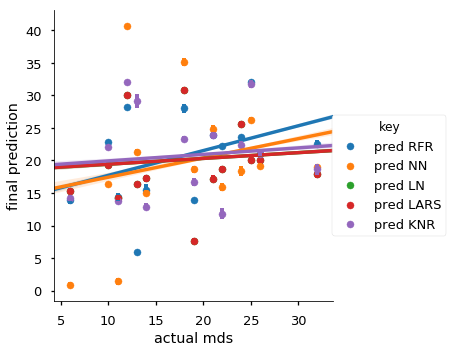

In [5]:
### DISPLAY FINAL PREDICTIONS ###
one_stack_predictions = pd.DataFrame()
for col in list(second_stack_predictions.columns.values)[2:]:
    df = pd.DataFrame()
    df['subj'] = second_stack_predictions['subj']
    df['actual mds'] = second_stack_predictions['actual mds']
    df['final prediction'] = second_stack_predictions[col]
    df['key'] = col
    one_stack_predictions = one_stack_predictions.append(df, ignore_index = True)

sns.lmplot(x = 'actual mds', y = 'final prediction', hue = 'key', data = one_stack_predictions, order = 1, x_estimator=np.mean)

In [6]:
# ### 1 stack followed by RFR ###
# print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred RFR'])[0][1].__str__())
# print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred RFR'].values))**2))).__str__()) 
# sns.lmplot(x = 'actual mds', y = 'pred RFR', data = second_stack_predictions, order = 1, x_estimator=np.mean)

In [7]:
# ### 1 stack followed by NN ###
# print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred NN'])[0][1].__str__())
# print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred NN'].values))**2))).__str__()) 
# sns.lmplot(x = 'actual mds', y = 'pred NN', data = second_stack_predictions, order = 1, x_estimator=np.mean)

In [8]:
# ### 1 stack followed by LN ###
# print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred LN'])[0][1].__str__())
# print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred LN'].values))**2))).__str__()) 
# sns.lmplot(x = 'actual mds', y = 'pred LN', data = second_stack_predictions, order = 1, x_estimator=np.mean)

In [9]:
# ### 1 stack followed by LARS ###
# print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred LARS'])[0][1].__str__())
# print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred LARS'].values))**2))).__str__()) 
# sns.lmplot(x = 'actual mds', y = 'pred LARS', data = second_stack_predictions, order = 1, x_estimator=np.mean)

In [10]:
# ### 1 stack followed by KNR ###
# print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred KNR'])[0][1].__str__())
# print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred KNR'].values))**2))).__str__()) 
# sns.lmplot(x = 'actual mds', y = 'pred KNR', data = second_stack_predictions, order = 1, x_estimator=np.mean)

In [11]:
### CALCULATE SECOND STACK FROM FIRST STACK - WITHOUT BASELINE ###

# setup needed variables
second_stack_predictions_RFR = []; second_stack_predictions_NN = []; second_stack_predictions_LN = []; 
second_stack_predictions_LARS = []; second_stack_predictions_KNR = []
actual_mds = []; baseline_mds = []; subjs2 = []

# create regressors
clf_stacked_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
clf_stacked_NN = MLPRegressor(max_iter = 10000, random_state = 2)
clf_stacked_LN = LinearRegression()
clf_stacked_LARS = Lars(eps = 2.220446049250313e-7)
clf_stacked_KNR = KNeighborsRegressor(weights = 'distance')

# use a leave one subject out method to train regressors
for s in stacked_predictions['subj'].unique():
    
    # set up train and test sets
    stacked_train = stacked_predictions[stacked_predictions.subj != s]
    stacked_test = stacked_predictions[stacked_predictions.subj == s]
    stacked_ytrain = stacked_train['actual mds'].values.astype(int)
    stacked_ytest = stacked_test['actual mds'].values.astype(int)
    bmds = stacked_test['baseline mds'].values.astype(int)
    stacked_train = stacked_train.iloc[:, 3:].values
    stacked_test = stacked_test.iloc[:, 3:].values
    
    # scale train and test sets
    scaler = StandardScaler() 
    scaler.fit(stacked_train)  
    stacked_train_std = scaler.transform(stacked_train)
    stacked_test_std = scaler.transform(stacked_test)
    
    # train models
    clf_stacked_RFR.fit(stacked_train, stacked_ytrain)
    clf_stacked_NN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LARS.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_KNR.fit(stacked_train_std, stacked_ytrain)
    
    # make predictions and store in second_stack_predictions
    if (len(stacked_test) != 0):
        actual_mds += list(stacked_ytest)
        baseline_mds += list(bmds)
        second_stack_predictions_RFR += list(clf_stacked_RFR.predict(stacked_test))
        second_stack_predictions_NN += list(clf_stacked_NN.predict(stacked_test_std))
        second_stack_predictions_LN += list(clf_stacked_LN.predict(stacked_test_std))
        second_stack_predictions_LARS += list(clf_stacked_LARS.predict(stacked_test_std))
        second_stack_predictions_KNR += list(clf_stacked_KNR.predict(stacked_test_std))
        subjs2 += [s for elem in list(stacked_ytest)]
second_stack_predictions = pd.DataFrame()
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'subj', value = np.array(subjs2))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'baseline mds', value = np.array(baseline_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred RFR', value = second_stack_predictions_RFR)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred NN', value = second_stack_predictions_NN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LN', value = second_stack_predictions_LN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LARS', value = second_stack_predictions_LARS)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred KNR', value = second_stack_predictions_KNR)
second_stack_predictions.corr()

,subj,actual mds,baseline mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,-0.084160,0.307093,0.236685,0.023482,0.258428,0.258428,0.027562
actual mds,-0.084160,1.000000,0.578731,-0.575623,-0.412726,-0.373619,-0.373619,-0.249886
baseline mds,0.307093,0.578731,1.000000,-0.315513,-0.325594,0.087899,0.087899,-0.229109
pred RFR,0.236685,-0.575623,-0.315513,1.000000,0.453797,0.552661,0.552661,0.675627
pred NN,0.023482,-0.412726,-0.325594,0.453797,1.000000,0.150913,0.150913,0.617300
pred LN,0.258428,-0.373619,0.087899,0.552661,0.150913,1.000000,1.000000,0.393197
pred LARS,0.258428,-0.373619,0.087899,0.552661,0.150913,1.000000,1.000000,0.393197
pred KNR,0.027562,-0.249886,-0.229109,0.675627,0.617300,0.393197,0.393197,1.000000


,subj,actual mds,final prediction
subj,1.000000,-0.084160,0.256194
actual mds,-0.084160,1.000000,0.570977
final prediction,0.256194,0.570977,1.000000


num data points: 4000
correlation coefficient: 0.5709774453881723
RMSE: 7.04458038623487
Cohen Kappa Score: 0.029615954653007037


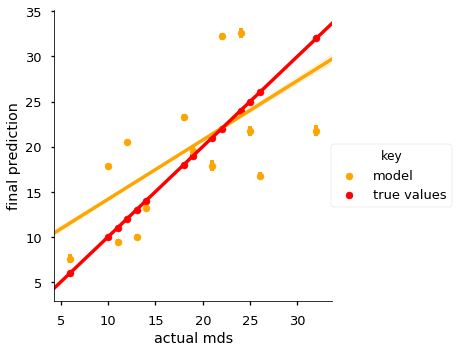

In [12]:
### CALCULATE FINAL PREDICTIONS FROM SECOND STACK ###

# build regressors
#clfs = [RandomForestRegressor(n_estimators=50, random_state = 2), MLPRegressor(max_iter = 10000, random_state = 2), 
#        LinearRegression(), Lars(eps = 2.220446049250313e-7), KNeighborsRegressor(weights = 'distance')]
clfs = [MLPRegressor(max_iter = 10000, random_state = 2)]

# display each model
for clf_final in clfs:
    
    # setup needed variables
    actual_mds = []; predictions_final = []; subjs3 = []
    
    # use a leave one subject out method to train models
    for s in second_stack_predictions['subj'].unique():

        # split test train data
        second_stack_train = second_stack_predictions[second_stack_predictions.subj != s]
        second_stack_test = second_stack_predictions[second_stack_predictions.subj == s]
        second_stack_ytrain = second_stack_train['actual mds'].values.astype(int)
        second_stack_ytest = second_stack_test['actual mds'].values.astype(int)
        second_stack_train = second_stack_train.iloc[:, 2:].values
        second_stack_test = second_stack_test.iloc[:, 2:].values
        
        # scale test and train data
        scaler = StandardScaler() 
        scaler.fit(second_stack_train)  
        second_stack_std = scaler.transform(second_stack_train)
        second_stack_test_std = scaler.transform(second_stack_test)
        
        # train regressor
        clf_final.fit(second_stack_train, second_stack_ytrain)
        
        # make predictions and store in predictions dataframe
        if (len(second_stack_test) != 0):
            actual_mds += list(second_stack_ytest)
            predictions_final += list(clf_final.predict(second_stack_test))
            subjs3 += [s for elem in list(second_stack_ytest)]
    # build predictions dataframe
    predictions = pd.DataFrame()
    predictions.insert(loc = len(predictions.columns.values), column = 'subj', value = np.array(subjs3))
    predictions.insert(loc = len(predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
    predictions.insert(loc = len(predictions.columns.values), column = 'final prediction', value = np.array(predictions_final))
    display(predictions.corr())
    
    # display results
    predictions['key'] = 'model'
    actual_for_comp = pd.DataFrame()
    actual_for_comp['subj'] = predictions['subj']
    actual_for_comp['actual mds'] = predictions['actual mds']
    actual_for_comp['final prediction'] = predictions['actual mds']
    actual_for_comp['key'] = 'true values'

    print("num data points: " + len(predictions.index.values).__str__())
    print('correlation coefficient: ' + np.corrcoef(predictions['final prediction'], predictions['actual mds'])[0][1].__str__())
    print('RMSE: ' + float(np.sqrt(np.mean((np.array(predictions['final prediction']) - predictions['actual mds'])**2))).__str__()) 
    print('Cohen Kappa Score: ' + cohen_kappa_score([int(p) for p in predictions['final prediction'].values], [int(p) for p in predictions['actual mds']]).__str__()) 
    
    df_display = predictions.append(actual_for_comp, ignore_index = True)
    colors = {'model': 'orange', 'true values': 'r'}
    sns.lmplot(x = 'actual mds', y = 'final prediction', hue = 'key', data = df_display, order = 1, x_estimator= np.mean, palette = colors)
    plt.show()